# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from skimage.io import imread
from skimage.transform import resize as imresize
import datetime
import os

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
from skimage.transform import resize
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train_doc = np.random.permutation(open('/content/drive/My Drive/Project_data/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/drive/My Drive/Project_data/Project_data/val.csv').readlines())
batch_size = 64

In [5]:
from keras import backend as K
from keras.layers import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, AveragePooling2D
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Bidirectional, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, GlobalAveragePooling3D, ConvLSTM2D

from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.regularizers import l2
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [6]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.arange(0,30,3) #create a list of image numbers you want to use for a particular video

    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),50,50,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    image = resize(image,(50,50))
                    image = image - np.percentile(image,5)/ np.percentile(image,95) - np.percentile(image,5)
                    batch_data[folder,idx,:,:,0] = image[:,:,0]
                    batch_data[folder,idx,:,:,1] = image[:,:,1]
                    batch_data[folder,idx,:,:,2] = image[:,:,2]

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        rem_image = len(folder_list)%batch_size

        batch += 1

        if(rem_image!=0):
            batch_data = np.zeros((rem_image,len(img_idx),50,50,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((rem_image,5)) # batch_labels is the one hot representation of the output

            for folder in range(rem_image): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    image = resize(image,(50,50))
                    image = image - np.percentile(image,5)/ np.percentile(image,95) - np.percentile(image,5)
                    batch_data[folder,idx,:,:,0] = image[:,:,0]
                    batch_data[folder,idx,:,:,1] = image[:,:,1]
                    batch_data[folder,idx,:,:,2] = image[:,:,2]

                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [7]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/My Drive/Project_data/Project_data/train'
val_path = '/content/drive/My Drive/Project_data/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)
num_classes = 5
batch_size = 32

# training sequences = 663
# validation sequences = 100
# epochs = 25


In [8]:
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## **Model 1**

In [ ]:

#write your model here
model = Sequential()
model.add(Conv3D(32,kernel_size=3,activation='relu',input_shape=(10,50,50,3)))
model.add(Conv3D(64,kernel_size=3,activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())

model.add(Conv3D(64,kernel_size=3,activation='relu'))
model.add(MaxPooling3D(pool_size=(1,2,2)))
model.add(BatchNormalization())

model.add(Conv3D(64,kernel_size=(1,3,3),activation='relu'))
model.add(MaxPooling3D(pool_size=(1,2,2)))
model.add(BatchNormalization())

model.add(Conv3D(64,kernel_size=(1,3,3),activation='relu'))
model.add(MaxPooling3D(pool_size=(1,2,2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5,activation='softmax'))



In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)  #write your optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 8, 48, 48, 32)     2624      
                                                                 
 conv3d_1 (Conv3D)           (None, 6, 46, 46, 64)     55360     
                                                                 
 max_pooling3d (MaxPooling3  (None, 3, 23, 23, 64)     0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 3, 23, 23, 64)     256       
 Normalization)                                                  
                                                                 
 conv3d_2 (Conv3D)           (None, 1, 21, 21, 64)     110656    
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 1, 10, 10, 64)     0

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init_exp_16' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
model1 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/My Drive/Project_data/Project_data/train ; batch size = 64
Epoch 1/25
11/11 [==============================] - ETA: 0s - loss: 2.4198 - categorical_accuracy: 0.3590  Source path =  /content/drive/My Drive/Project_data/Project_data/val ; batch size = 64

Epoch 1: saving model to model_init_exp_16_2023-10-1012_32_11.200412/model-00001-2.41977-0.35897-992.81592-0.18000.h5
11/11 [==============================] - 2511s 249s/step - loss: 2.4198 - categorical_accuracy: 0.3590 - val_loss: 992.8159 - val_categorical_accuracy: 0.1800 - lr: 0.0100
Epoch 2/25
11/11 [==============================] - ETA: 0s - loss: 1.3571 - categorical_accuracy: 0.5008
Epoch 2: saving model to model_init_exp_16_2023-10-1012_32_11.200412/model-00002-1.35708-0.50075-445.28250-0.20000.h5
11/11 [==============================] - 73s 7s/step - loss: 1.3571 - categorical_accuracy: 0.5008 - val_loss: 445.2825 - val_categorical_accuracy: 0.2000 - lr: 0.0100
Epoch 3/25
11/11 [================

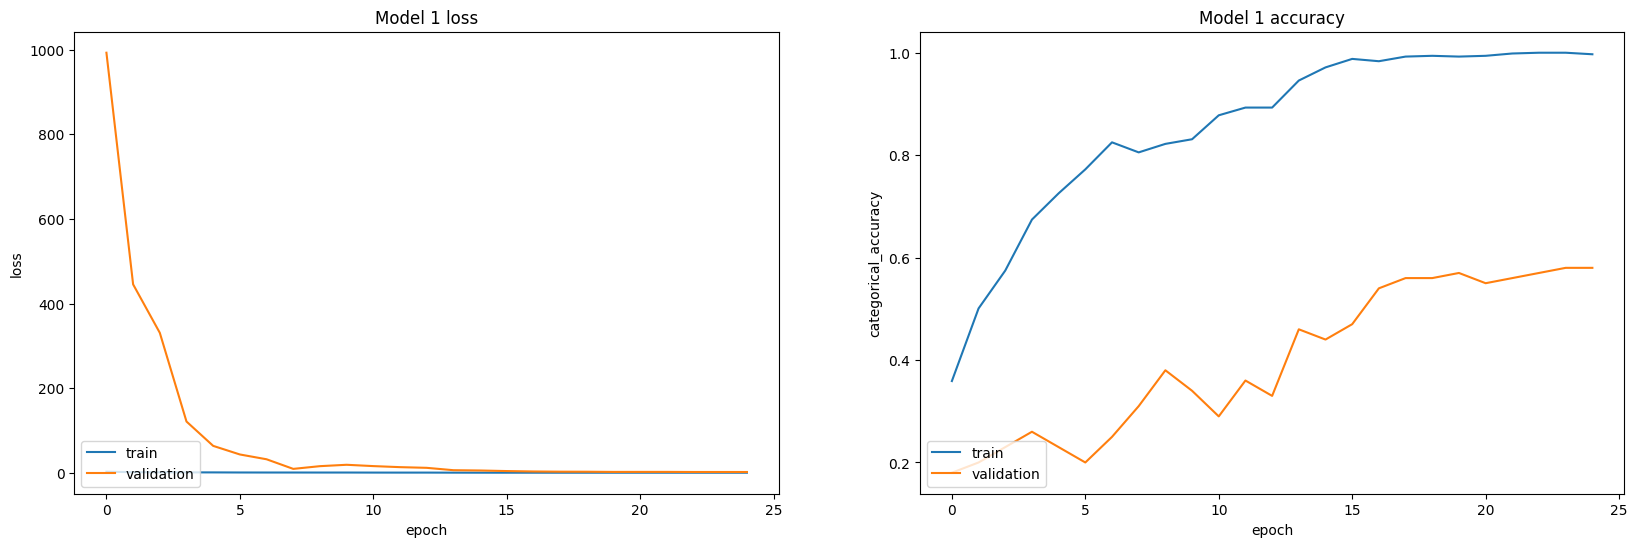

In [ ]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(model1.history['loss'])
ax1 = plt.plot(model1.history['val_loss'])
plt.title('Model 1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(model1.history['categorical_accuracy'])
ax2 = plt.plot(model1.history['val_categorical_accuracy'])
plt.title('Model 1 accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')


# Model 2

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/My Drive/Project_data/Project_data/train'
val_path = '/content/drive/My Drive/Project_data/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15
print ('# epochs =', num_epochs)
num_classes = 5
batch_size = 32

# training sequences = 663
# validation sequences = 100
# epochs = 30


In [ ]:
#model 2
model = Sequential()
model.add(Conv3D(32,kernel_size=3,activation='relu',input_shape=(10,50,50,3)))
model.add(Conv3D(64,kernel_size=3,activation='relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv3D(128,kernel_size=3,activation='relu'))
model.add(MaxPooling3D(pool_size=(1,2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv3D(256,kernel_size=(1,3,3),activation='relu'))
model.add(MaxPooling3D(pool_size=(1,2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv3D(512,kernel_size=(1,3,3),activation='relu'))
model.add(MaxPooling3D(pool_size=(1,2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5,activation='softmax'))

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)  #write your optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_5 (Conv3D)           (None, 8, 48, 48, 32)     2624      
                                                                 
 conv3d_6 (Conv3D)           (None, 6, 46, 46, 64)     55360     
                                                                 
 max_pooling3d_4 (MaxPoolin  (None, 3, 23, 23, 64)     0         
 g3D)                                                            
                                                                 
 batch_normalization_5 (Bat  (None, 3, 23, 23, 64)     256       
 chNormalization)                                                
                                                                 
 dropout (Dropout)           (None, 3, 23, 23, 64)     0         
                                                                 
 conv3d_7 (Conv3D)           (None, 1, 21, 21, 128)   

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:
model_name = 'model_init_exp_16' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
model2 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/My Drive/Project_data/Project_data/train ; batch size = 64
Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 3.1372 - categorical_accuracy: 0.2986Source path =  /content/drive/My Drive/Project_data/Project_data/val ; batch size = 64

Epoch 1: saving model to model_init_exp_16_2023-10-1013_48_27.754339/model-00001-3.13716-0.29864-3967.06348-0.21000.h5
11/11 [==============================] - 94s 9s/step - loss: 3.1372 - categorical_accuracy: 0.2986 - val_loss: 3967.0635 - val_categorical_accuracy: 0.2100 - lr: 0.0100
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 1.4888 - categorical_accuracy: 0.4314
Epoch 2: saving model to model_init_exp_16_2023-10-1013_48_27.754339/model-00002-1.48877-0.43137-1510.75879-0.22000.h5
11/11 [==============================] - 71s 7s/step - loss: 1.4888 - categorical_accuracy: 0.4314 - val_loss: 1510.7588 - val_categorical_accuracy: 0.2200 - lr: 0.0100
Epoch 3/30
11/11 [==================

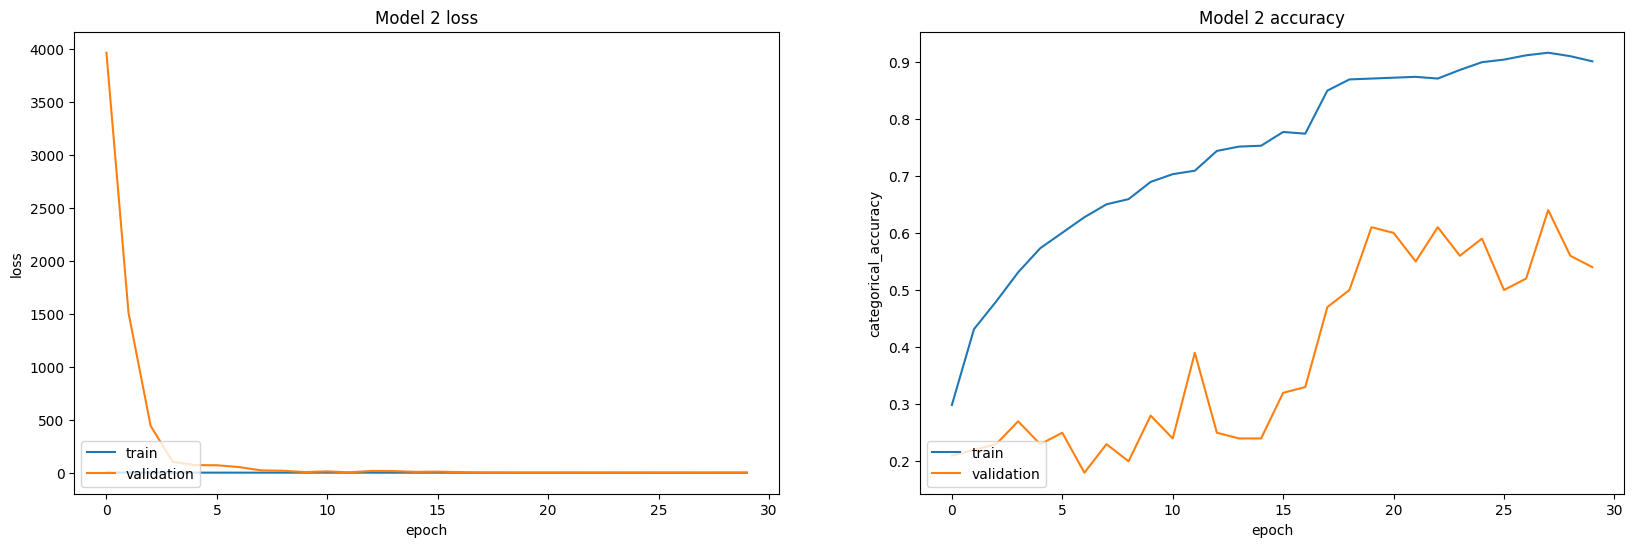

In [ ]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(model2.history['loss'])
ax1 = plt.plot(model2.history['val_loss'])
plt.title('Model 2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(model2.history['categorical_accuracy'])
ax2 = plt.plot(model2.history['val_categorical_accuracy'])
plt.title('Model 2 accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

# Model 3

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/My Drive/Project_data/Project_data/train'
val_path = '/content/drive/My Drive/Project_data/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30
print ('# epochs =', num_epochs)
num_classes = 5
batch_size = 64

In [ ]:
# model3

model = Sequential()

model.add(TimeDistributed(Conv2D(16,(3,3),activation='relu'),input_shape=(10,50,50,3)))
model.add(TimeDistributed(MaxPooling2D(2,2)))
model.add(BatchNormalization())

model.add(TimeDistributed(Conv2D(32,(3,3),activation='relu')))
model.add(TimeDistributed(MaxPooling2D(2,2)))
model.add(BatchNormalization())

model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(TimeDistributed(Dense(32,activation='relu')))
model.add(BatchNormalization())

model.add(GRU(128))
model.add(BatchNormalization())
model.add(Dense(5,activation='softmax'))







Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)  #write your optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 10, 48, 48, 16)    448       
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 10, 24, 24, 16)    0         
 stributed)                                                      
                                                                 
 batch_normalization_10 (Ba  (None, 10, 24, 24, 16)    64        
 tchNormalization)                                               
                                                                 
 time_distributed_2 (TimeDi  (None, 10, 22, 22, 32)    4640      
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 10, 11, 11, 32)   

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:

model_name = 'model_init_exp_16' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [ ]:
model3 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/My Drive/Project_data/Project_data/train ; batch size = 64


In [ ]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(model3.history['loss'])
ax1 = plt.plot(model3.history['val_loss'])
plt.title('Model 3 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(model3.history['categorical_accuracy'])
ax2 = plt.plot(model3.history['val_categorical_accuracy'])
plt.title('Model 3 accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

# Model 4

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/My Drive/Project_data/Project_data/train'
val_path = '/content/drive/My Drive/Project_data/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15
print ('# epochs =', num_epochs)
num_classes = 5
batch_size = 32

In [ ]:
model = Sequential()
model.add(TimeDistributed(Conv2D(8,(3,3),activation='relu'),input_shape=(10,50,50,3)))
model.add(BatchNormalization())

model.add(TimeDistributed(Conv2D(16,(3,3),activation='relu')))
model.add(BatchNormalization())

model.add(ConvLSTM2D(8,kernel_size=3,return_sequences=False))
model.add(TimeDistributed(Dense(64,activation='relu')))
model.add(BatchNormalization())

model.add(GlobalAveragePooling2D())
model.add(Dense(64,activation='relu'))
model.add(Dense(5,activation='softmax'))



In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)  #write your optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

In [ ]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [ ]:

model_name = 'model_init_exp_16' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

In [ ]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
model4 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

In [ ]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(model4.history['loss'])
ax1 = plt.plot(model4.history['val_loss'])
plt.title('Model 4 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(model4.history['categorical_accuracy'])
ax2 = plt.plot(model4.history['val_categorical_accuracy'])
plt.title('Model 4 accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

# Model 5

In [ ]:
curr_dt_time = datetime.datetime.now()
train_path = '/content/drive/My Drive/Project_data/Project_data/train'
val_path = '/content/drive/My Drive/Project_data/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 15
print ('# epochs =', num_epochs)
num_classes = 5
batch_size = 32

In [9]:
model = Sequential()
model.add(TimeDistributed(Conv2D(16,(2,2),padding='same'),input_shape=(10,50,50,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(Conv2D(16,(2,2))))
model.add(Activation('relu'))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
model.add(Dropout(0.25))

model.add(TimeDistributed(Conv2D(32,(2,2),padding='same')))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(TimeDistributed(Conv2D(32,(2,2))))
model.add(Activation('relu'))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
model.add(Dropout(0.25))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(256,return_sequences=False,dropout=0.5))
model.add(Dense(64,kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))



In [10]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)  #write your optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 10, 50, 50, 16)    208       
 ributed)                                                        
                                                                 
 activation (Activation)     (None, 10, 50, 50, 16)    0         
                                                                 
 batch_normalization (Batch  (None, 10, 50, 50, 16)    64        
 Normalization)                                                  
                                                                 
 time_distributed_1 (TimeDi  (None, 10, 49, 49, 16)    1040      
 stributed)                                                      
                                                                 
 activation_1 (Activation)   (None, 10, 49, 49, 16)    0         
                                                        

In [11]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [12]:

model_name = 'model_init_exp_16' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

In [13]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
model5 = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /content/drive/My Drive/Project_data/Project_data/train ; batch size = 64
Epoch 1/25
 4/11 [=========>....................] - ETA: 1:08:50 - loss: 2.7285 - categorical_accuracy: 0.2461

In [ ]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(model5.history['loss'])
ax1 = plt.plot(model5.history['val_loss'])
plt.title('Model 5 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(model5.history['categorical_accuracy'])
ax2 = plt.plot(model5.history['val_categorical_accuracy'])
plt.title('Model 5 accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')